In [ ]:
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-08-12 07:44:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.192.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-08-12 07:44:01 (191 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [ ]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

text = []
labels = []

for item in datastore:
    text.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sentences=[]
for row in text:
  for word in stop_words:
    token = " " + word + " "
    row = row.replace(token, " ")
  sentences.append(row)

In [ ]:
len(text) , len(sentences)

(26709, 26709)

In [ ]:
labels[0], text[0] , sentences[0]

(0,
 "former versace store clerk sues over secret 'black code' for minority shoppers",
 "former versace store clerk sues secret 'black code' minority shoppers")

In [ ]:
labels[2], text[2] , sentences[2]

(1,
 "mom starting to fear son's web series closest thing she will have to grandchild",
 "mom starting fear son's web series closest thing grandchild")

In [ ]:
#vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
vocab_size=len(word_index)
len(word_index)


25637

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## With simple EMBEDDING LAYER

### without stop words

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.01)
Earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           409808    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 410,241
Trainable params: 410,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model1.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[Earlystop,reduce_lr],shuffle=False)

Epoch 1/30
625/625 - 4s - loss: 0.6820 - accuracy: 0.5603 - val_loss: 0.6680 - val_accuracy: 0.5633
Epoch 2/30
625/625 - 3s - loss: 0.5856 - accuracy: 0.6773 - val_loss: 0.4837 - val_accuracy: 0.7989
Epoch 3/30
625/625 - 3s - loss: 0.3686 - accuracy: 0.8531 - val_loss: 0.3993 - val_accuracy: 0.8152
Epoch 4/30
625/625 - 3s - loss: 0.2861 - accuracy: 0.8857 - val_loss: 0.3951 - val_accuracy: 0.8174
Epoch 5/30
625/625 - 4s - loss: 0.2458 - accuracy: 0.9031 - val_loss: 0.4041 - val_accuracy: 0.8186
Epoch 6/30
625/625 - 4s - loss: 0.2177 - accuracy: 0.9155 - val_loss: 0.4186 - val_accuracy: 0.8210
Epoch 7/30
625/625 - 3s - loss: 0.1959 - accuracy: 0.9240 - val_loss: 0.4367 - val_accuracy: 0.8216


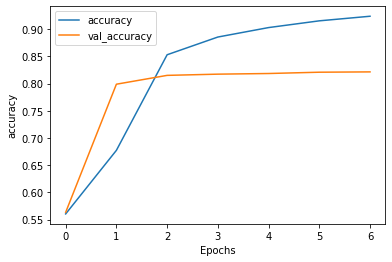

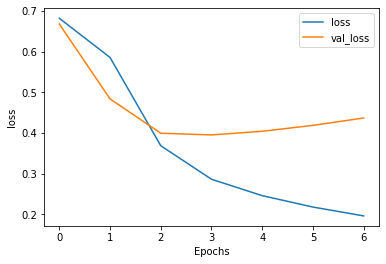

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### with stop words

In [ ]:
sentences=[]
labels=[]
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           409808    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 410,241
Trainable params: 410,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[Earlystop,reduce_lr])

Epoch 1/30
625/625 - 4s - loss: 0.6727 - accuracy: 0.5806 - val_loss: 0.5979 - val_accuracy: 0.7930
Epoch 2/30
625/625 - 3s - loss: 0.4341 - accuracy: 0.8346 - val_loss: 0.3855 - val_accuracy: 0.8360
Epoch 3/30
625/625 - 4s - loss: 0.3022 - accuracy: 0.8826 - val_loss: 0.3580 - val_accuracy: 0.8435
Epoch 4/30
625/625 - 3s - loss: 0.2384 - accuracy: 0.9128 - val_loss: 0.3384 - val_accuracy: 0.8580
Epoch 5/30
625/625 - 3s - loss: 0.1931 - accuracy: 0.9318 - val_loss: 0.3461 - val_accuracy: 0.8523
Epoch 6/30
625/625 - 4s - loss: 0.1577 - accuracy: 0.9458 - val_loss: 0.3590 - val_accuracy: 0.8486
Epoch 7/30
625/625 - 3s - loss: 0.1287 - accuracy: 0.9579 - val_loss: 0.3532 - val_accuracy: 0.8594


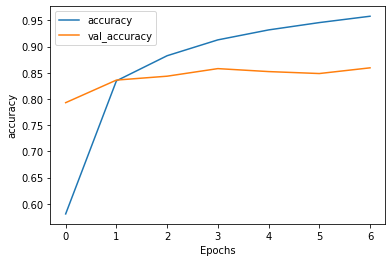

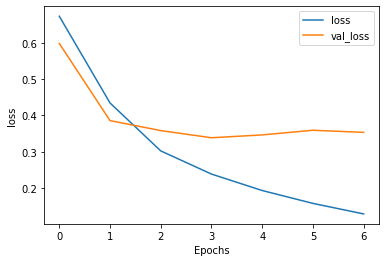

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
##### thus with stopwords it gives better accuracy!!!!!!!

## with CONV Layer

In [ ]:
model3= tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           409808    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 423,297
Trainable params: 423,297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 50
history = model3.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[Earlystop,reduce_lr])

Epoch 1/50
625/625 - 9s - loss: 0.4452 - accuracy: 0.7782 - val_loss: 0.3562 - val_accuracy: 0.8444
Epoch 2/50
625/625 - 9s - loss: 0.1902 - accuracy: 0.9276 - val_loss: 0.3661 - val_accuracy: 0.8509
Epoch 3/50
625/625 - 9s - loss: 0.0629 - accuracy: 0.9800 - val_loss: 0.5235 - val_accuracy: 0.8344
Epoch 4/50
625/625 - 8s - loss: 0.0158 - accuracy: 0.9961 - val_loss: 0.6711 - val_accuracy: 0.8374


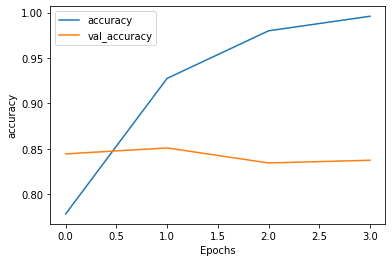

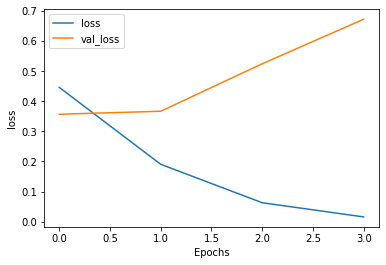

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## with bidirectional

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           409808    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 423,937
Trainable params: 423,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model4.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2,callbacks=[Earlystop,reduce_lr])

Epoch 1/50
625/625 - 29s - loss: 0.4112 - accuracy: 0.7994 - val_loss: 0.3158 - val_accuracy: 0.8645
Epoch 2/50
625/625 - 28s - loss: 0.1690 - accuracy: 0.9342 - val_loss: 0.3448 - val_accuracy: 0.8606
Epoch 3/50
625/625 - 28s - loss: 0.0626 - accuracy: 0.9786 - val_loss: 0.4569 - val_accuracy: 0.8547
Epoch 4/50
625/625 - 28s - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.5439 - val_accuracy: 0.8495


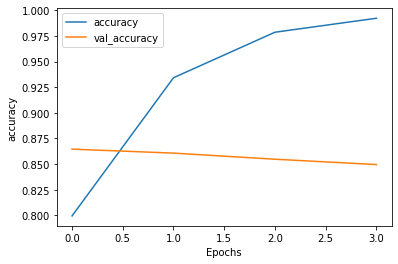

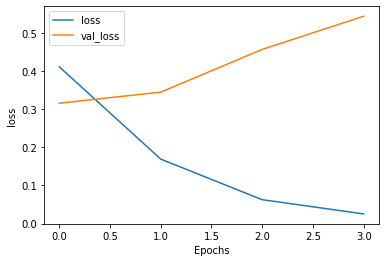

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')